## MLND Capstone :: Carvana Image Masking Challenge

In [1]:
import time

import numpy as np
import pandas as pd
from scipy import ndimage
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns
import cv2

In [2]:
# %load utils/params.py
PROJECT_PATH = '.'
INPUT_PATH = PROJECT_PATH + '/input'

METADATA_CSV_PATH = INPUT_PATH + '/metadata.csv'

TRAIN_MASKS_CSV_PATH = INPUT_PATH + '/train_masks.csv'
TRAIN_PATH = INPUT_PATH + '/train'
TRAIN_MASKS_PATH = INPUT_PATH + '/train_masks'

INPUT_SIZE = 128
BATCH_SIZE = 16
MAX_EPOCHS = 100

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True

In [4]:
train_masks = pd.read_csv(TRAIN_MASKS_CSV_PATH)
    
metadata = pd.read_csv(METADATA_CSV_PATH)
    
# train_masks.head()

In [5]:
# %load utils/filename.py
import utils.params

def filename_to_code(filename):
    car_code, angle_code = filename.split('.')[0].split('_')
    return car_code, angle_code

def code_to_filename(car_code, angle_code, mask = False):
    return car_code + '_' + angle_code + ('_mask.gif' if mask else '.jpg')

def get_full_path(filename, mask = False):
    if mask is True:
        return TRAIN_MASKS_PATH + '/' + filename
    else :
        return TRAIN_PATH + '/' + filename
    
def get_filepath_from_code(car_code, angle_code, mask = False):
    return get_full_path(code_to_filename(car_code, angle_code, mask), mask)

In [6]:
# %load utils/image.py
from scipy import ndimage
from matplotlib import pyplot as plt
import seaborn as sns
import cv2

def read_image(car_code, angle_code, mask = False):
    img_path = get_filepath_from_code(car_code, angle_code, mask)
    img = None
    if mask is True:
        img = ndimage.imread(img_path, mode = 'L')
#         img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#         img = cv2.resize(img, (INPUT_SIZE, INPUT_SIZE))
        img[img <= 127] = 0
        img[img > 127] = 1        
    else :
        img = ndimage.imread(img_path)
#         img = cv2.imread(img_path)
                
    return img
        
def resize(image):
    img = cv2.resize(image, (INPUT_SIZE, INPUT_SIZE))
    return img
    
def show_image(car_code, angle_code, mask = False):
    car_img = read_image(car_code, angle_code, mask)    
    plt.imshow(car_img)
    plt.show()


0d1a9caf4350 14
1e89e1af42e7 07
2a4a8964ebf3 08
4a4364d7fc6d 14
4f0397cf7937 05
6ba36af67cb0 07


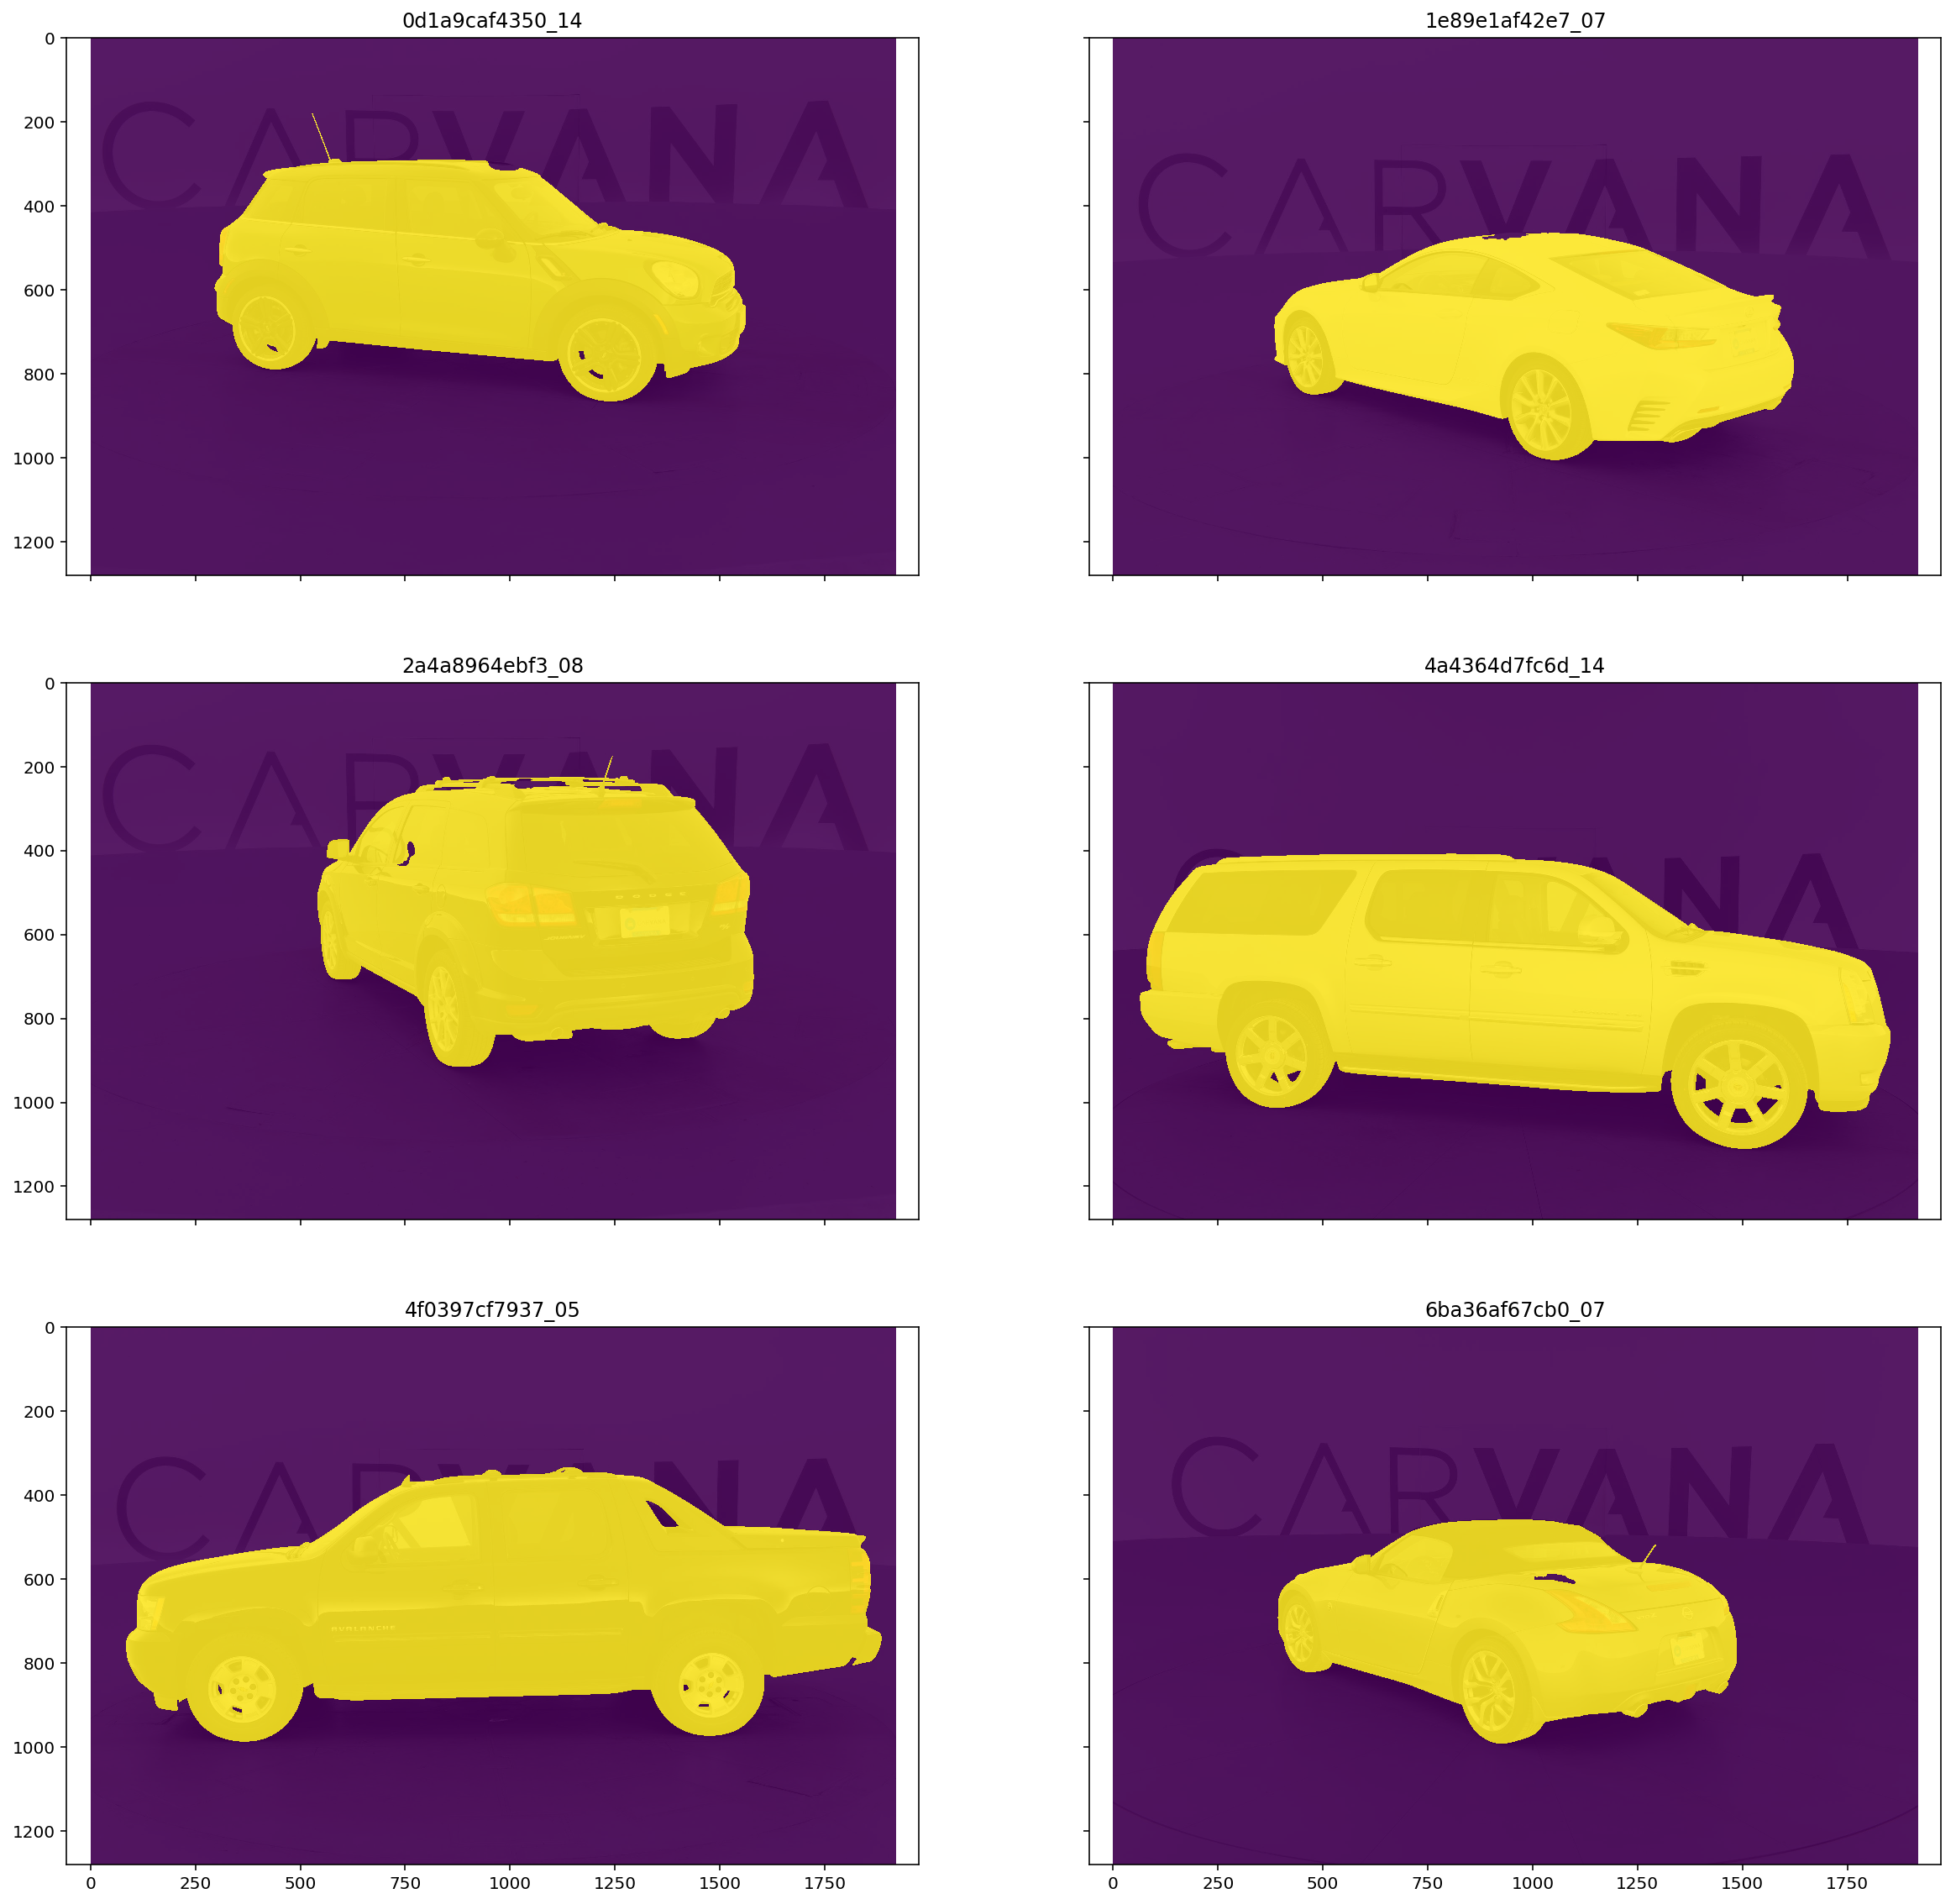

In [62]:
# curropted_masks =  ['0d1a9caf4350_14', '1e89e1af42e7_07', '2a4a8964ebf3_08', 
#                     '2ea62c1beee7_03', '2faf504842df_03', '2faf504842df_12' ]
# curropted_masks =  ['3afec4b5ac07_05', '3afec4b5ac07_12', '3afec4b5ac07_13', 
#                     '3afec4b5ac07_14', '3bca821c8c41_13', '4a4364d7fc6d_06' ] 
# curropted_masks =  ['4a4364d7fc6d_07', '4a4364d7fc6d_14', '4a4364d7fc6d_15', 
#                     '4baf50a3d8c2_05', '4e5ac4b9f074_11', '4f1f065d78ac_14' ]
# curropted_masks =  ['4f0397cf7937_05', '5df60cf7cab2_07', '5df60cf7cab2_15', 
#                     '6ba36af67cb0_07', '6bff9e10288e_01' ]
curropted_masks =  ['0d1a9caf4350_14', '1e89e1af42e7_07', '2a4a8964ebf3_08', 
                    '4a4364d7fc6d_14', '4f0397cf7937_05', '6ba36af67cb0_07' ]



# Sample some images from the dataset and show them in a grid
def vis_curropted_dataset(add_masks = True):
    ncols = 2
    nrows = int(np.ceil(len(curropted_masks)/ncols))
#     print(ncols, nrows)
    f, ax = plt.subplots(nrows = nrows, ncols = ncols, sharex = True, sharey = True, figsize=(20, 20))
    sampled_imgs = np.random.choice(train_masks['img'], nrows*ncols)
#     sampled_imgs = [TRAIN_PATH + '/' + i for i in sampled_imgs]
    
    counter = 0
    for i in range(nrows):
        for j in range(ncols):
            if counter < len(curropted_masks):                            
                car_code, angle_code = filename_to_code(curropted_masks[counter])
                print (car_code, angle_code)
                image = read_image(car_code, angle_code)
                ax[i, j].imshow(image)

                if add_masks:
                    mask = read_image(car_code, angle_code, True)
    #                 mix = cv2.bitwise_and(image, image, mask = mask)                    
                    ax[i, j].imshow(mask, alpha = 0.9)
                    ax[i, j].set_title(curropted_masks[counter])
    #                 ax[i, j].imshow(mix, cmap = 'Greys_r', alpha = 0.6)
                counter += 1
    plt.show()
    
vis_curropted_dataset()

In [11]:
# %load utils/preprocess.py
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
import seaborn as sns
import cv2

from utils.params import *

def randomHueSaturationVariation(image, hue_shift_limit =(-180, 180), sat_shift_limit = (-255, 255),
                                 val_shift_limit = (-255, 255), u = 0.5 ):
    if np.random.random() < u :
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(image)
        hue_shift = np.random.uniform(hue_shift_limit[0], hue_shift_limit[1])
        h = cv2.add(h, hue_shift)
        sat_shift = np.random.uniform(sat_shift_limit[0], sat_shift_limit[1])
        s = cv2.add(s, sat_shift)
        val_shift = np.random.uniform(val_shift_limit[0], val_shift_limit[1])
        v = cv2.add(v, val_shift)
        image = cv2.merge((h, s, v))
        image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
    
    return image

def randomShiftScaleRotate(image, mask,
                           shift_limit=(-0.0625, 0.0625),
                           scale_limit=(-0.1, 0.1),
                           rotate_limit=(-45, 45), aspect_limit=(0, 0),
                           borderMode=cv2.BORDER_REFLECT, u=0.5):
    if np.random.random() < u:
        height, width, channel = image.shape

        angle = np.random.uniform(rotate_limit[0], rotate_limit[1])  # degree
        scale = np.random.uniform(1 + scale_limit[0], 1 + scale_limit[1])
        aspect = np.random.uniform(1 + aspect_limit[0], 1 + aspect_limit[1])
        sx = scale * aspect / (aspect ** 0.5)
        sy = scale / (aspect ** 0.5)
        dx = round(np.random.uniform(shift_limit[0], shift_limit[1]) * width)
        dy = round(np.random.uniform(shift_limit[0], shift_limit[1]) * height)

        cc = np.math.cos(angle / 180 * np.math.pi) * sx
        ss = np.math.sin(angle / 180 * np.math.pi) * sy
        rotate_matrix = np.array([[cc, -ss], [ss, cc]])

        box0 = np.array([[0, 0], [width, 0], [width, height], [0, height], ])
        box1 = box0 - np.array([width / 2, height / 2])
        box1 = np.dot(box1, rotate_matrix.T) + np.array([width / 2 + dx, height / 2 + dy])

        box0 = box0.astype(np.float32)
        box1 = box1.astype(np.float32)
        mat = cv2.getPerspectiveTransform(box0, box1)
        image = cv2.warpPerspective(image, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                    borderValue=(
                                        0, 0,
                                        0,))
        mask = cv2.warpPerspective(mask, mat, (width, height), flags=cv2.INTER_LINEAR, borderMode=borderMode,
                                   borderValue=(
                                       0, 0,
                                       0,))

    return image, mask

def randomHorizontalFlip(image, mask, u=0.5):
    if np.random.random() < u:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)

    return image, mask

def randomCrop(image, mask, u = 0.5):
    if np.random.random() < u:
        height, width, channel = image.shape
        cropL = int(np.random.uniform(0, width/50))
        cropR = int(np.random.uniform(0, width/50))
        cropT = int(np.random.uniform(0, width/50))
        cropB = int(np.random.uniform(0, width/50))
        image = image[cropT:height-cropB, cropL:width - cropR]
        image = resize(image)
        
        mask = mask[cropT:height-cropB, cropL:width - cropR]
        mask = resize(mask)
        
    return image, mask

In [17]:
INPUT_SIZE = 512

# Sample some images from the dataset and show them in a grid
def vis_augmented_dataset(nrows = 2, ncols = 2):
    f, ax = plt.subplots(nrows = nrows, ncols = ncols, sharex = True, sharey = True, figsize=(20,20))
    sampled_imgs = np.random.choice(train_masks['img'], nrows*ncols)
#     sampled_imgs = [TRAIN_PATH + '/' + i for i in sampled_imgs]
    
    counter = 0
    for i in range(nrows):
        for j in range(ncols):
            car_code, angle_code = filename_to_code(sampled_imgs[counter])
            image = read_image(car_code, angle_code)
            image = resize(image)

            
            mask = read_image(car_code, angle_code, True)
            mask = resize(mask)
            image = randomHueSaturationVariation(image, hue_shift_limit=(-50,50),
                                                 sat_shift_limit=(-5, 5), val_shift_limit=(-15, 15))
            image, mask = randomShiftScaleRotate(image, mask,  rotate_limit=(-5, 5))
            image, mask = randomHorizontalFlip(image, mask)
            #image, mask = randomCrop(image, mask)

            ax[i, j].imshow(image)
            
            #                 mix = cv2.bitwise_and(image, image, mask = mask)                    
            ax[i, j].imshow(mask, alpha = 0.4)
#                 ax[i, j].imshow(mix, cmap = 'Greys_r', alpha = 0.6)
            counter += 1
    plt.show()

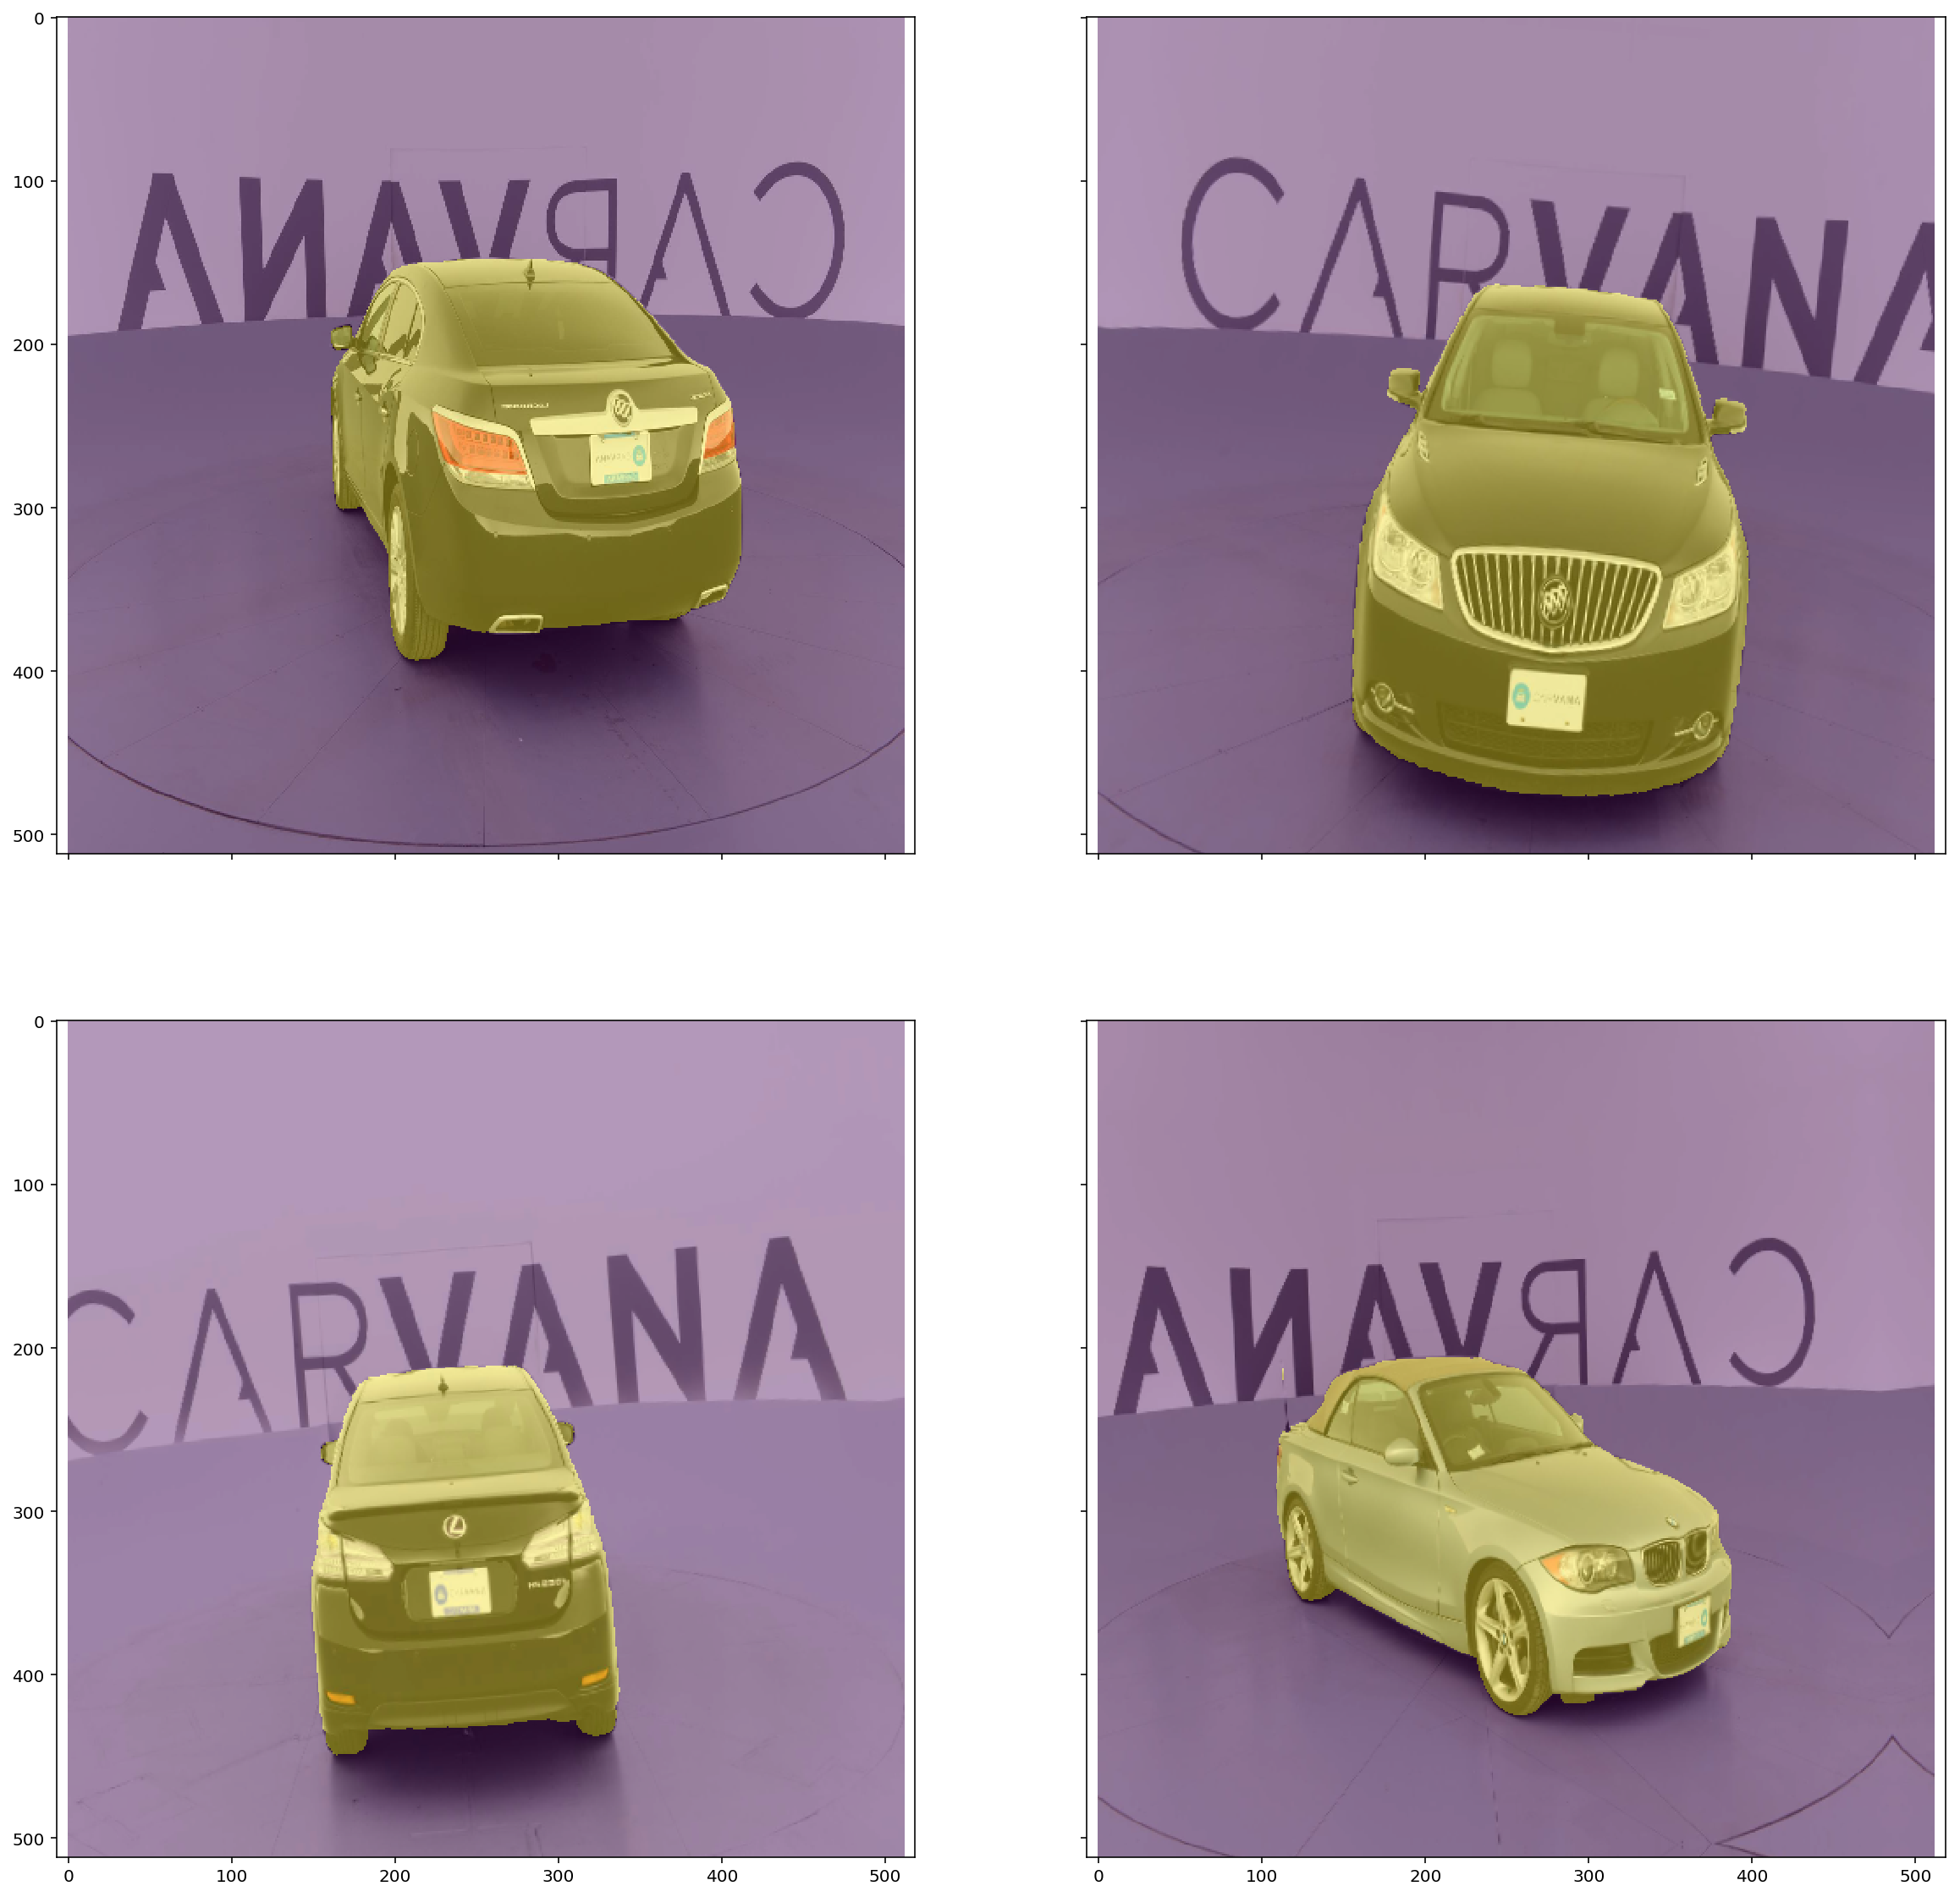

In [18]:
vis_augmented_dataset()

In [53]:
sample_car_code = '00087a6bd4dc'

sample_angle_code = '04'

car_img = read_image(sample_car_code, sample_angle_code)
car_img.shape
car_img = car_img[10:1280 , 0:1900] 
car_img.shape

(1280, 1918, 3)

(1270, 1900, 3)

In [ ]:

# Sample some images from the dataset and show them in a grid
def vis_dataset(nrows = 5, ncols = 5, add_masks = False):
    f, ax = plt.subplots(nrows = nrows, ncols = ncols, sharex = True, sharey = True, figsize=(20,20))
    sampled_imgs = np.random.choice(train_masks['img'], nrows*ncols)
#     sampled_imgs = [TRAIN_PATH + '/' + i for i in sampled_imgs]
    
    counter = 0
    for i in range(nrows):
        for j in range(ncols):
            car_code, angle_code = filename_to_code(sampled_imgs[counter])
            image = read_image(car_code, angle_code)
            ax[i, j].imshow(image)
            
            if add_masks:
                mask = read_image(car_code, angle_code, True)
#                 mix = cv2.bitwise_and(image, image, mask = mask)                    
                ax[i, j].imshow(mask, alpha = 0.4)
#                 ax[i, j].imshow(mix, cmap = 'Greys_r', alpha = 0.6)
            counter += 1
    plt.show()